Loading Dataset

In [28]:
import pandas as pd

In [29]:
df=pd.read_csv("Data.csv")

In [30]:
df.head()

,depth,RPM,Flow,WOB,ROP,well
0,25.96,54.947292,2.711315,10.80726,17.310000,A
1,26.27,54.947292,2.711315,10.80726,18.630000,A
2,26.59,61.540000,2.711315,10.80726,5.660000,A
3,26.90,60.230000,2.711315,10.80726,11.670000,A
4,27.24,61.750000,2.711315,10.80726,12.804158,A


Dataset Overview

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7311 entries, 0 to 7310
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   depth   7311 non-null   float64
 1   RPM     7311 non-null   float64
 2   Flow    7311 non-null   float64
 3   WOB     7311 non-null   float64
 4   ROP     7311 non-null   float64
 5   well    7311 non-null   object 
dtypes: float64(5), object(1)
memory usage: 342.8+ KB


In [32]:
df.describe()

,depth,RPM,Flow,WOB,ROP
count,7311.000000,7311.000000,7311.000000,7311.000000,7311.000000
mean,1168.864378,57.169230,2.734865,10.775011,10.352387
std,654.527243,21.055557,0.412798,3.745654,10.448501
min,25.960000,1.690000,1.665580,0.181410,0.220000
25%,600.545000,39.920000,2.356950,8.609975,3.480000
50%,1173.990000,53.280000,2.659360,10.807260,5.490000
75%,1734.710000,74.985000,3.099950,13.460320,12.804158
max,2296.940000,119.610000,4.049060,20.698410,47.400000


In [33]:
df.isnull().sum()

depth    0
RPM      0
Flow     0
WOB      0
ROP      0
well     0
dtype: int64

In [34]:
print(df['well'].unique())
print("Unique count:", df['well'].nunique())

['A']
Unique count: 1


Check Outliers

In [35]:
import matplotlib.pyplot as plt

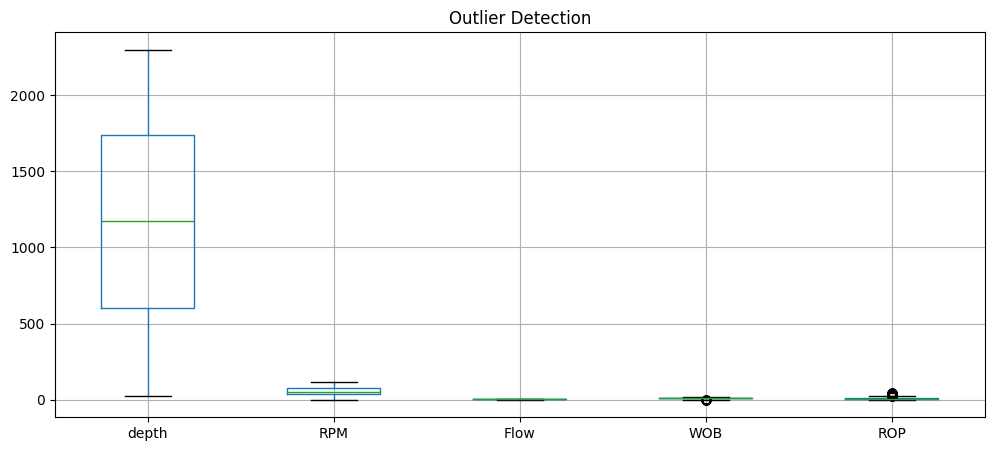

In [36]:
plt.figure(figsize=(12, 5))
df.boxplot()
plt.title("Outlier Detection")
plt.show()

In [37]:
def count_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: Found {len(outliers)} outliers")


features_to_check = ['depth', 'RPM', 'WOB', 'Flow', 'ROP']
count_outliers(df, features_to_check)

depth: Found 0 outliers
RPM: Found 0 outliers
WOB: Found 46 outliers
Flow: Found 0 outliers
ROP: Found 848 outliers


In [38]:
import seaborn as sns
import numpy as np

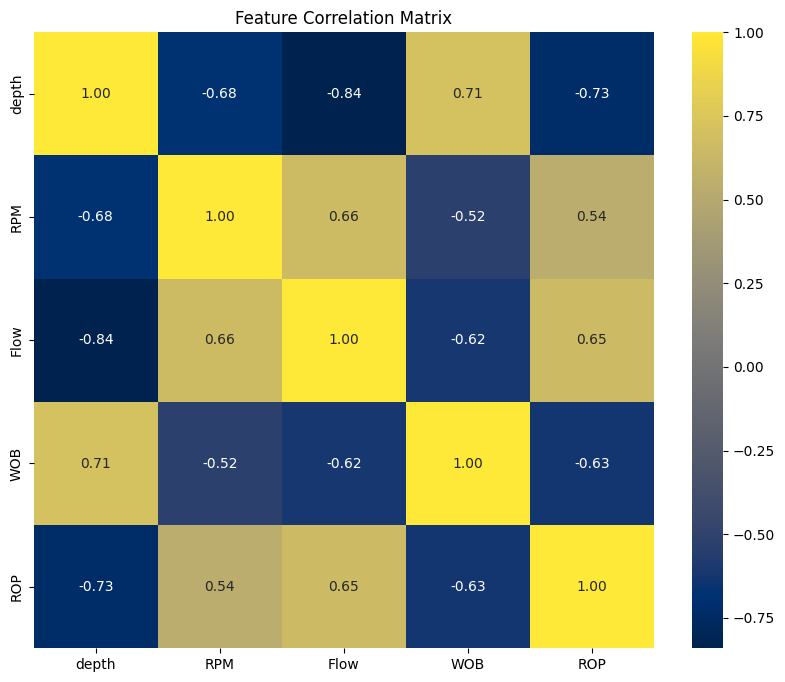

In [39]:
plt.figure(figsize=(10, 8))

numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='cividis', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

Data Preprocessing

In [40]:
df.drop(['well'],axis=1,inplace=True)

In [41]:
df.head()

,depth,RPM,Flow,WOB,ROP
0,25.96,54.947292,2.711315,10.80726,17.310000
1,26.27,54.947292,2.711315,10.80726,18.630000
2,26.59,61.540000,2.711315,10.80726,5.660000
3,26.90,60.230000,2.711315,10.80726,11.670000
4,27.24,61.750000,2.711315,10.80726,12.804158


Savitzky–Golay Filtering

In [42]:
from scipy.signal import savgol_filter

In [43]:
df['RPM_sg']  = savgol_filter(df['RPM'],  window_length=7, polyorder=2)
df['WOB_sg']  = savgol_filter(df['WOB'],  window_length=7, polyorder=2)
df['Flow_sg'] = savgol_filter(df['Flow'], window_length=7, polyorder=2)


In [44]:
df.head()

,depth,RPM,Flow,WOB,ROP,RPM_sg,WOB_sg,Flow_sg
0,25.96,54.947292,2.711315,10.80726,17.310000,54.288160,9.561714,2.711315
1,26.27,54.947292,2.711315,10.80726,18.630000,57.091830,11.554588,2.711315
2,26.59,61.540000,2.711315,10.80726,5.660000,59.283512,12.301916,2.711315
3,26.90,60.230000,2.711315,10.80726,11.670000,60.863204,11.803697,2.711315
4,27.24,61.750000,2.711315,10.80726,12.804158,62.028829,9.312604,2.711315


In [45]:
df=df.drop(['RPM', 'WOB', 'Flow'],axis=1)

In [46]:
df = df[['depth', 'RPM_sg', 'WOB_sg', 'Flow_sg', 'ROP']]

In [47]:
df.head()

,depth,RPM_sg,WOB_sg,Flow_sg,ROP
0,25.96,54.288160,9.561714,2.711315,17.310000
1,26.27,57.091830,11.554588,2.711315,18.630000
2,26.59,59.283512,12.301916,2.711315,5.660000
3,26.90,60.863204,11.803697,2.711315,11.670000
4,27.24,62.028829,9.312604,2.711315,12.804158


Feature Engineering

In [48]:
df['dRPM']  = df['RPM_sg'].diff()
df['dWOB']  = df['WOB_sg'].diff()
df['dFlow'] = df['Flow_sg'].diff()
df['RPM_WOB_ratio'] = df['RPM_sg'] / (df['WOB_sg'] + 1)
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

C:\Users\Asus\AppData\Local\Temp\ipykernel_17152\71746543.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_17152\71746543.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [49]:
df.head()

,depth,RPM_sg,WOB_sg,Flow_sg,ROP,dRPM,dWOB,dFlow,RPM_WOB_ratio
0,25.96,54.288160,9.561714,2.711315,17.310000,2.803671,1.992874,1.332268e-15,5.140090
1,26.27,57.091830,11.554588,2.711315,18.630000,2.803671,1.992874,1.332268e-15,4.547487
2,26.59,59.283512,12.301916,2.711315,5.660000,2.191682,0.747328,4.440892e-16,4.456765
3,26.90,60.863204,11.803697,2.711315,11.670000,1.579692,-0.498219,1.332268e-15,4.753565
4,27.24,62.028829,9.312604,2.711315,12.804158,1.165625,-2.491093,0.000000e+00,6.014856


In [50]:
df = df[['depth', 'RPM_sg', 'WOB_sg', 'Flow_sg', 'dRPM', 'dWOB', 'dFlow', 'RPM_WOB_ratio', 'ROP']]
df.head()


,depth,RPM_sg,WOB_sg,Flow_sg,dRPM,dWOB,dFlow,RPM_WOB_ratio,ROP
0,25.96,54.288160,9.561714,2.711315,2.803671,1.992874,1.332268e-15,5.140090,17.310000
1,26.27,57.091830,11.554588,2.711315,2.803671,1.992874,1.332268e-15,4.547487,18.630000
2,26.59,59.283512,12.301916,2.711315,2.191682,0.747328,4.440892e-16,4.456765,5.660000
3,26.90,60.863204,11.803697,2.711315,1.579692,-0.498219,1.332268e-15,4.753565,11.670000
4,27.24,62.028829,9.312604,2.711315,1.165625,-2.491093,0.000000e+00,6.014856,12.804158


In [51]:
X=df.iloc[:,:-1].values
y=df.iloc[:,-1].values

In [52]:
X

array([[2.59600000e+01, 5.42881598e+01, 9.56171357e+00, ...,
        1.99287429e+00, 1.33226763e-15, 5.14009014e+00],
       [2.62700000e+01, 5.70918304e+01, 1.15545879e+01, ...,
        1.99287429e+00, 1.33226763e-15, 4.54748743e+00],
       [2.65900000e+01, 5.92835119e+01, 1.23019157e+01, ...,
        7.47327857e-01, 4.44089210e-16, 4.45676497e+00],
       ...,
       [2.29632000e+03, 3.47078571e+01, 1.38351171e+01, ...,
        2.73180952e-02, 2.30334762e-01, 2.33957419e+00],
       [2.29663000e+03, 3.47692857e+01, 1.38681579e+01, ...,
        3.30407143e-02, 4.11952143e-01, 2.33850663e+00],
       [2.29694000e+03, 3.51376190e+01, 1.39069212e+01, ...,
        3.87633333e-02, 5.93569524e-01, 2.35713456e+00]], shape=(7311, 8))

In [53]:
y

array([17.31, 18.63,  5.66, ...,  3.85,  4.49,  3.95], shape=(7311,))

Data Set Split

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

Building Model and Training

In [56]:
import xgboost

In [66]:
model=xgboost.XGBRegressor(max_depth=2,learning_rate=0.1,n_estimators=200)

In [67]:
model.fit(X_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [68]:
y_pred=model.predict(X_test)

In [69]:
y_pred

array([13.313544 , 11.861256 , 11.998665 , ..., 32.72027  ,  3.1492374,
        2.802604 ], shape=(1463,), dtype=float32)

In [70]:
y_test

array([16.39,  8.38, 12.33, ..., 25.29,  2.74,  2.88], shape=(1463,))

Evaluation the model

R-Squared

In [71]:
from sklearn.metrics import r2_score

In [72]:
r2=r2_score(y_test,y_pred)
print(r2)

0.858071828371416


Adjusted R-Squared

In [73]:
k=X_test.shape[1]
n=X_test.shape[0]
adj_r2=1-(1-r2)*(n-1)/(n-k-1)

In [74]:
print(adj_r2)

0.8572909305907911


K fold cross validation

In [75]:
from sklearn.model_selection import cross_val_score

In [76]:
r2s=cross_val_score(estimator=model,
                    X=X,
                    y=y,
                    scoring='r2',
                    cv=10)

In [77]:
print("Average R-Squred:{:.3f}".format(r2s.mean()))
print("Standard Deviation:{:.3f}".format(r2s.std()))

Average R-Squred:-0.691
Standard Deviation:0.476


In [78]:
import joblib

In [79]:
joblib.dump(model, "rop_prediction_model.pkl")
print("\nModel saved as 'rop_prediction_model.pkl'")


Model saved as 'rop_prediction_model.pkl'


Plot Model with Actual Vs Predictions

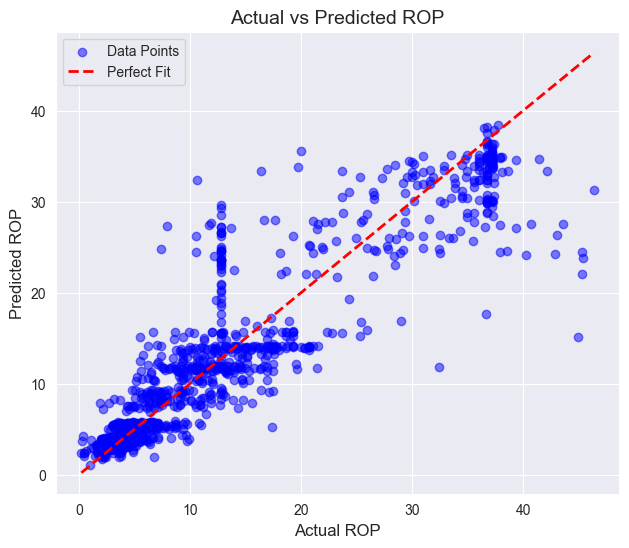

In [85]:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Data Points')

min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Actual vs Predicted ROP', fontsize=14)
plt.xlabel('Actual ROP', fontsize=12)
plt.ylabel('Predicted ROP', fontsize=12)
plt.legend()